# 模型选择、欠拟合和过拟合

In [20]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

给定 $x$，我们将使用以下三阶多项式来生成训练和测试数据的标签：

$$ y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2). $$

噪声项$\epsilon$ 从均值为 0 且标准差为 0.1 的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将特征从 $x^i$ 调整为 $\frac{x^i}{i}$ 的原因，这样可以避免很大的 $i$ 带来的特别大的指数值。我们将为训练集和测试集各生成 100 个样本。


In [21]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
epsilon = np.random.normal(scale=0.1, size=labels.shape)
labels += epsilon

In [22]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.0075],
         [-2.5002]]),
 tensor([[ 1.0000e+00, -1.0075e+00,  5.0751e-01, -1.7044e-01,  4.2928e-02,
          -8.6498e-03,  1.4524e-03, -2.0904e-04,  2.6326e-05, -2.9470e-06,
           2.9690e-07, -2.7193e-08,  2.2830e-09, -1.7693e-10,  1.2733e-11,
          -8.5519e-13,  5.3850e-14, -3.1913e-15,  1.7862e-16, -9.4715e-18],
         [ 1.0000e+00, -2.5002e+00,  3.1255e+00, -2.6048e+00,  1.6281e+00,
          -8.1411e-01,  3.3924e-01, -1.2117e-01,  3.7867e-02, -1.0520e-02,
           2.6301e-03, -5.9779e-04,  1.2455e-04, -2.3954e-05,  4.2778e-06,
          -7.1302e-07,  1.1142e-07, -1.6386e-08,  2.2760e-09, -2.9950e-10]]),
 tensor([  0.9789, -23.2795]))

In [23]:
print(features.shape)
print(poly_features.shape)
print(labels.shape)
print(true_w.shape)

torch.Size([200, 1])
torch.Size([200, 20])
torch.Size([200])
torch.Size([20])


In [24]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [25]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9716115  1.198432  -3.378883   5.606522 ]]


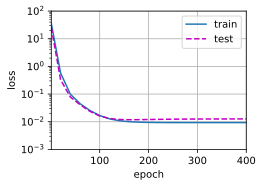

In [26]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.7943354 5.45641  ]]


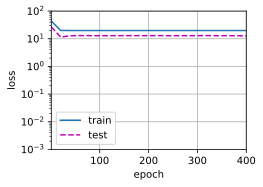

In [27]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.976888    1.2067115  -3.4010587   5.512902   -0.03815922  0.43071568
   0.58448654 -0.1849419   0.21095753  0.03186762  0.09358852 -0.18465333
   0.07196728  0.00826317 -0.02130827  0.18626347  0.11506873 -0.09942908
  -0.02755495  0.05218924]]


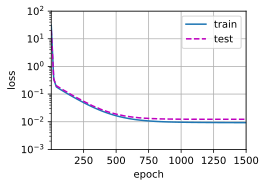

In [28]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [29]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [30]:
import torch
import numpy as np
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # (20, )

features = np.random.normal(size=(n_train + n_test, 1))  # (200,1)
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree))
# np.arange(1, max_degree + 1) (20, ) -> (1, 20) -> (200, 20)
print(poly_features.shape)

(200, 20)


给定 $x$，我们将使用以下三阶多项式来生成训练和测试数据的标签：

$$ y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2). $$

噪声项$\epsilon$ 从均值为 0 且标准差为 0.1 的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将特征从 $x^i$ 调整为 $\frac{x^i}{i}$ 的原因，这样可以避免很大的 $i$ 带来的特别大的指数值。我们将为训练集和测试集各生成 100 个样本。


In [31]:
### 目前我们有的是一个(200, 20)维的矩阵，即200条数据，每一条数据都是1 + x + x^2 + ...
import math
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)

### After multiplying the coefficient of the equation:
### true_w is of shape (20,)
# label = poly_features * true_w
label = np.dot(poly_features, true_w)
epsilon = np.random.normal(scale=0.1, size=label.shape)
label += epsilon

In [32]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, label = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, label]]

features[:2], poly_features[:2, :], label[:2]

(tensor([[ 1.2320],
         [-0.9644]]),
 tensor([[ 1.0000e+00,  1.2320e+00,  7.5893e-01,  3.1167e-01,  9.5996e-02,
           2.3654e-02,  4.8570e-03,  8.5484e-04,  1.3165e-04,  1.8021e-05,
           2.2202e-06,  2.4867e-07,  2.5531e-08,  2.4195e-09,  2.1292e-10,
           1.7488e-11,  1.3466e-12,  9.7591e-14,  6.6797e-15,  4.3313e-16],
         [ 1.0000e+00, -9.6435e-01,  4.6499e-01, -1.4947e-01,  3.6035e-02,
          -6.9501e-03,  1.1171e-03, -1.5389e-04,  1.8551e-05, -1.9877e-06,
           1.9168e-07, -1.6805e-08,  1.3505e-09, -1.0018e-10,  6.9005e-12,
          -4.4363e-13,  2.6739e-14, -1.5168e-15,  8.1262e-17, -4.1245e-18]]),
 tensor([5.7625, 1.3731]))

In [33]:
print(features.shape)
print(poly_features.shape)
print(labels.shape)
print(true_w.shape)

torch.Size([200, 1])
torch.Size([200, 20])
torch.Size([200])
torch.Size([20])


In [34]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        pred = net(X)
        l = loss(pred, y)
        metric.add(l.sum(), y.numel())
    return metric[0] / metric[1]

In [35]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    # 初始化为: metric.data = [0.0, 0.0]
    with torch.no_grad():
        for X, y in data_iter: # (batch_size, feature_size)
            metric.add(accuracy(net(X), y), y.numel()) # y.numel() gives the number of elements in y
            print(metric.data)
    return metric[0] / metric[1]

In [36]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
        print(metric.data)
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    # animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9], legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        # animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [37]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def __train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    loss = nn.MSELoss(reduction='none')
    net = nn.Sequential(nn.Linear(train_features.shape[-1], 1))
    net.apply(init_weights)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    loss = nn.MSELoss(reduction='none')
    net = nn.Sequential(nn.Linear(train_features.shape[-1], 1))
    net.apply(init_weights)
    trainer = torch.optim.SGD(net.parameters(), lr=0.1)
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, trainer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    # train_loss, train_acc = train_metrics
    # assert train_loss < 0.5, train_loss
    # assert train_acc <= 1 and train_acc > 0.7, train_acc
    # assert test_acc <= 1 and test_acc > 0.7, test_acc

In [38]:
def train_(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

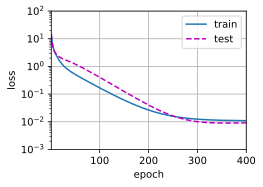

In [39]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      label[:n_train], label[n_train:])

## <font color = red> 权重衰减 </font>

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们[**像以前一样生成一些数据**]，生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。


In [3]:
# n_train, n_test, num_inputs, batch_size = 200, 100, 10, 5
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [4]:
print(test_data[0].shape)
print(test_data[1].shape)
features, labels = train_data
print(features.shape)
print(labels.shape)

torch.Size([100, 200])
torch.Size([100, 1])
torch.Size([20, 200])
torch.Size([20, 1])


In [5]:
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

#### 初始化模型参数

In [6]:
d = 200
num_inputs = d

w = torch.normal(0, 0.01, size=(num_inputs, 1), requires_grad = True)
b = torch.normal(0, 0.01, size=(1, ), requires_grad = True)

"""
b = torch.zeros(1, requires_grad=True)
"""

'\nb = torch.zeros(1, requires_grad=True)\n'

### 定义$L_2$范数惩罚

In [7]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss_L2(y_hat, y):
    return ((y_hat - y.reshape(y_hat.shape)) ** 2 + 2 * torch.sum(w.pow(2))) / 2

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

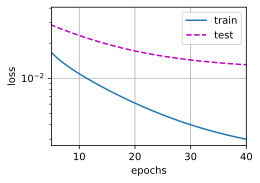

In [8]:
lr = 0.005
num_epochs = 40
# net = linreg
loss = squared_loss_L2
features, labels = train_data
animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])

for epoch in range(num_epochs):
    for X, y in train_iter:
        # print(X.shape, y.shape)
        net = lambda X: d2l.linreg(X, w, b)
        l = loss(net(X), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        y_hat = net(features)
        train_l = loss(y_hat, labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))

In [9]:
print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 0.05184062942862511


In [10]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

w的L2范数是： 13.187807083129883


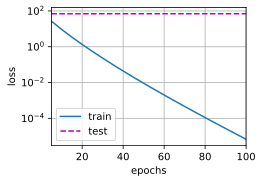

In [11]:
train(lambd=0)

w的L2范数是： 3.8410120010375977


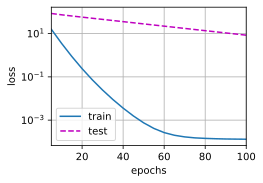

In [12]:
train(lambd=1)

w的L2范数是： 1.1439884901046753


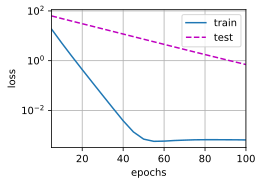

In [13]:
train(lambd=2)

## 手写Dropout

会用到: torch.rand Returns a tensor filled with random numbers from a uniform distribution on the interval $[0,1)$

## 从零开始实现

要实现单层的暂退法函数，
我们从均匀分布$U[0, 1]$中抽取样本，样本数与这层神经网络的维度一致。
然后我们保留那些对应样本大于$p$的节点，把剩下的丢弃。

在下面的代码中，(**我们实现 `dropout_layer` 函数，
该函数以`dropout`的概率丢弃张量输入`X`中的元素**)，
如上所述重新缩放剩余部分：将剩余部分除以`1.0-dropout`。

In [14]:
import torch
from torch import nn
from d2l import torch as d2l


def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros(size=X.shape)
    elif dropout == 0:
        return X
    else:
        mask = torch.rand(size=X.shape)
        cmp = (mask >= dropout).float()
        return mask*cmp / (1.0 - dropout)

In [15]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[1.2183, 0.0000, 1.7525, 0.0000, 0.0000, 0.0000, 1.3584, 0.0000],
        [1.4720, 1.8422, 0.0000, 1.8414, 1.7281, 0.0000, 0.0000, 1.4419]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


### 定义模型参数

同样，我们使用 :numref:`sec_fashion_mnist`中引入的Fashion-MNIST数据集。
我们[**定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元**]。


In [16]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [40]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

# net = nn.Sequential(nn.Flatten(),nn.Linear(784, num_hiddens1), nn.Dropout(), nn.ReLU(), 
#               nn.Linear(num_hiddens1, num_hiddens2), nn.Dropout(), nn.ReLU(),
#               nn.Linear(num_hiddens2, 10))

net = nn.Sequential(nn.Flatten(),nn.Linear(784, num_hiddens1), nn.ReLU(), nn.Dropout(),  
              nn.Linear(num_hiddens1, num_hiddens2), nn.ReLU(), nn.Dropout(),
              nn.Linear(num_hiddens2, 10))

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

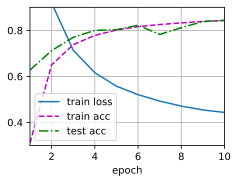

In [41]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

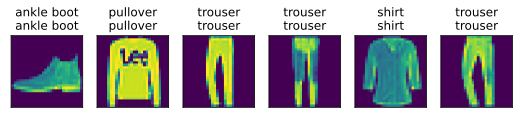

In [19]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)